# Newspaper Topic Modeling
Let's use this space to topic mine some of the headlines from the American Stories dataset from Harvard. First, let's get some basic libraries and packages installed for the analysis.

### Data Ingestion and Cleaning
I ingest the data from the Dell Lab's American Stories dataset on Hugging Face. I ingest two datasets: one with years in range(1800, 1970, 10) (notice that the step size is 10) and one with years in range (1935, 1945, 1) with step size 1.

I then do some experimenting with different methods of cleaning data using some of the techniques we used in class. I compare Pandas, PyTorch, and Python's built-in list comprehensions on their speed in cleaning textual data.

### Model Building
- **Base Model** - This model is trained on newspapers whose publication is in interval [1800 - 1970] with a step size of 10. This is to get a general sense of trends over 170 years of publication.
- **Reduced Model** - Once I have a general sense of the topics from 1800 - 1970, I reduce the scope of the datset to 1935 - 1945 for a more focused analysis of newspaper topics during wartime.
- **Interesting Model** - Finally, I cherry-pick the sources that seem most interesting to me (local to Michigan, notable titles, minority-serving, etc) and examine the trends in those papers specifically.

### Model Evaluation
The BERT model is unsupervised, which means there's no labelled data that I can use to guide the dataset toward some ideal, it does that on its own. It also means there's no external validation I can do on the documents themselves, and so I instead explore coherence scores that are specifically used for evaluating performance of unsupervices topic modelling algorithms.

### Analysis and Final Notes
I go through the topic analysis from my 3 different models and make notes about the things I find interesting.

In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('src')))

from data_cleaning import subsample_hf_dataset
from data_aggregation import yearly_word_counts 
from data_cleaning import isolate_interesting_sources

from data_aggregation import load_dataset_wrapper

from time_efficiency import test_time_efficiency
from data_cleaning import perform_list_comp_cleaning

import config

import joypy
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import colormaps as cm

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/kennonstewart/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kennonstewart/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Data Ingestion + Cleaning
At first, I only ingested newspaper data from every 10 years. I did this to explore the general trends in data and decide on which subset of that timeframe, if any, I would use for a deeper-dive into its content.

After going through the data from that wider subset, I realized that I was especially interested in the decade from 1935 - 1945, which encompasses World War II. I import this data into a dataset named dataset_1930. 

In [2]:
%%time

dataset = load_dataset_wrapper("GENERAL")

Analysis will be performed on the years 1800 to 1970 in steps of 10
CPU times: user 175 ms, sys: 192 ms, total: 367 ms
Wall time: 1.68 s


In [3]:
%%time
dataset_1930 = load_dataset_wrapper("RESTRICTED")

Analysis will be performed on the years 1935 to 1945 in steps of 1
CPU times: user 74 ms, sys: 117 ms, total: 191 ms
Wall time: 1.15 s


In [4]:
%%time
word_counts = yearly_word_counts(dataset)
word_counts_1930 = yearly_word_counts(dataset_1930)

Number of articles in 1800: 45
Number of articles in 1810: 982
Number of articles in 1820: 433
Number of articles in 1830: 4232
Number of articles in 1840: 8052
Number of articles in 1850: 49992
Number of articles in 1860: 150590
Number of articles in 1870: 174061
Number of articles in 1880: 272352
Number of articles in 1890: 540615
Number of articles in 1900: 1118970
Number of articles in 1910: 1684263
Number of articles in 1920: 2041192
Number of articles in 1930: 492695
Number of articles in 1940: 496662
Number of articles in 1950: 415416
Number of articles in 1960: 344550
Number of articles in 1935: 635554
Number of articles in 1936: 662015
Number of articles in 1937: 676549
Number of articles in 1938: 665274
Number of articles in 1939: 556283
Number of articles in 1940: 496662
Number of articles in 1941: 637200
Number of articles in 1942: 523923
Number of articles in 1943: 467200
Number of articles in 1944: 433769
CPU times: user 1min 18s, sys: 5.78 s, total: 1min 23s
Wall time: 1

I thought a cool analysis would be the progression of article length through the years. My informal hypothesis was that article length would steadily decrease as the years progressed. This would be in-line with today's trend of shorter articles, but I realized that the scope of my dataset doesn't allow for a more current analysis after the creation of the internet. From what I can see, article length is pretty consistent through much of the 19th and 20th centuries.

I also notice that, since a single year contains multiple sources, there's going to be a lot of variation in terms of word count. One year can have an article stretch from 15 words to 2000 words. To account for this range, I do a log transformation on the word counts to shorten the tails of the distributions.

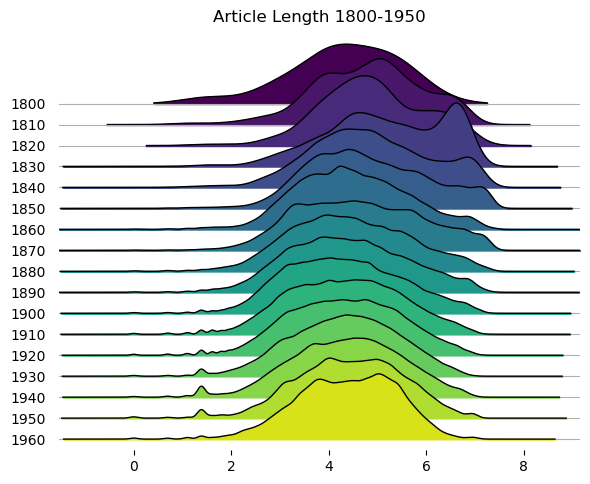

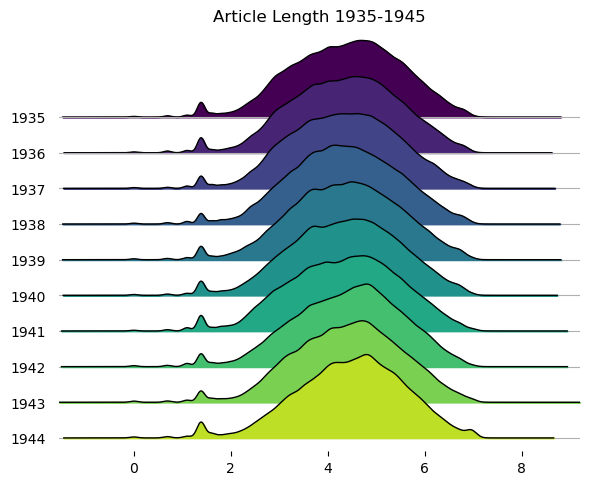

In [5]:
fig, axes = joypy.joyplot(word_counts, by="year", column="log_word_count", range_style='own',
                          grid="y", linewidth=1, legend=False, figsize=(6,5),
                          title="Article Length 1800-1950",
                          background="w",
                          colormap=cm.get_cmap('viridis'))
fig, axes = joypy.joyplot(word_counts_1930, by="year", column="log_word_count", range_style='own',
                          grid="y", linewidth=1, legend=False, figsize=(6,5),
                          title="Article Length 1935-1945",
                          background="w",
                          colormap=cm.get_cmap('viridis'))

It's not realistic to train a model on all of my article data since the corpus is so large. Instead, I'll sample ~5000 rows from every year to create a representative subsample of the population on which a smaller training set can be built.

One thing I don't do is stratify my subsample. The Detroit News may only publish monthly whereas the Detroit Free Press publishes weekly. If I don't have similar proportions of both, then the training set will unwittingly undervalue those sources that publish on less of a frequent basis. This is definitely a point of future improvement.

Another thing to note is that the shuffling induces randomness, which could likely change the results of the analysis. I try to reduce this randomness by setting the seed value to 42, but there may be variations in the embeddings and the analysis itself.

In [6]:
sampled_dataset = subsample_hf_dataset(dataset,config.SUBSAMPLE_SAMPLE_SIZE)
sampled_dataset_1930 = subsample_hf_dataset(dataset_1930, config.SUBSAMPLE_SAMPLE_SIZE)

subsampling dataset with seed value 42
sample size of year 1800: 45
sample size of year 1810: 982
sample size of year 1820: 433
sample size of year 1830: 4232
sample size of year 1840: 5000
sample size of year 1850: 5000
sample size of year 1860: 5000
sample size of year 1870: 5000
sample size of year 1880: 5000
sample size of year 1890: 5000
sample size of year 1900: 5000
sample size of year 1910: 5000
sample size of year 1920: 5000
sample size of year 1930: 5000
sample size of year 1940: 5000
sample size of year 1950: 5000
sample size of year 1960: 5000
subsample hf datasets: shape of dataset before cleaning: (70692, 8)
perform list comprehension cleaning: shape of dataset after cleaning: (70692, 8)
subsampling dataset with seed value 42
sample size of year 1935: 5000
sample size of year 1936: 5000
sample size of year 1937: 5000
sample size of year 1938: 5000
sample size of year 1939: 5000
sample size of year 1940: 5000
sample size of year 1941: 5000
sample size of year 1942: 5000
sa

### Text Pre-Processing Efficiency

One huge bottleneck in my pipeline is the time it takes to clean the data. To produce high-quality embeddings, I'd like to remove words that were mis-scanned due to low-quality scanning technology. This would ideally remove any word not recognized as English to make the article corpus a bit more legible to the topic modeler. I'd also like to remove stop words that take up space in my dataset, but contain little information about the semantic meaning of an article (ie. from, to, at).

In order to do this sort of cleaning quickly, I'm exploring some data structures introduced in class for processing massive amount of data including a Pandas DataFrame, Numpy Array, and PyTorch tensor.

## Testing at Scale

I wasn't sure how to best structure my tests, so I asked ChatGPT for some assistance. It showed me that it's possible to store actual functions as the value in a dictionary such that we can iteratively move through different algorithms effectively without hard-coding their function names.

In [7]:
# get a subsample of 500 articles
test_set = sampled_dataset.sample(config.TIME_EFFICIENCY_SAMPLE_SIZE, 
                                  random_state=config.SUBSAMPLE_SEED_VALUE)

# test the time efficiency of different text cleaning methods
results = test_time_efficiency(test_set["article"])

Progress: 0.20%
list_comprehension took 0.001044 seconds
--------------------------------------------------
numpy took 0.001406 seconds
--------------------------------------------------
pandas took 0.056849 seconds
--------------------------------------------------
pytorch took 0.065157 seconds
--------------------------------------------------
Progress: 0.40%
list_comprehension took 0.000104 seconds
--------------------------------------------------
numpy took 0.000162 seconds
--------------------------------------------------
pandas took 0.054387 seconds
--------------------------------------------------
pytorch took 0.057320 seconds
--------------------------------------------------
Progress: 0.60%
list_comprehension took 0.000117 seconds
--------------------------------------------------
numpy took 0.000175 seconds
--------------------------------------------------
pandas took 0.055815 seconds
--------------------------------------------------
pytorch took 0.052248 seconds
-------

I fit the model on the subsampled AS dataset with a minimum of pre-defined hyperparameters. The goal is to see what the model determines and then tweak from there. The first goal is to produce the embeddings using the BERTopic module, and then we're able to do some timeseries analysis using the topics_over_time method. 

This is critical. The usual TF-IDF embedding method assumes a constant set of data that needs to be clustered by topic. We actually have different classes of documents that need to be accounted for in the form of timestamps. When we analyze the topics using topics_over_time, we intentionally switch to a class-based TF-IDF embedding method that is better equipped to handle semantic changes in the topics over time.

Text(0, 0.5, 'Time(seconds)')

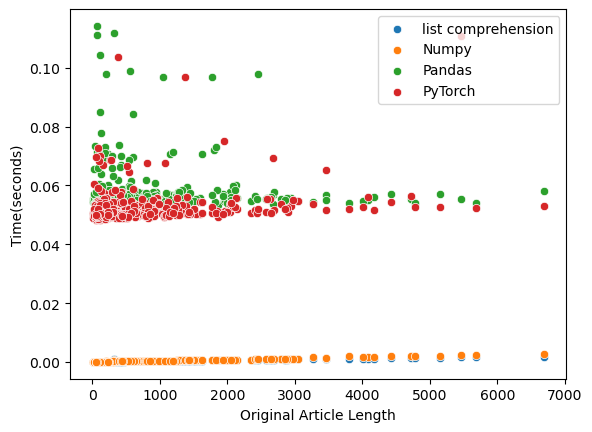

In [8]:
# plot the list_comprehension_time, numpy_time, and pandas_time against the original_article_length
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=results, x="original_article_length", 
                y="list_comprehension_time", 
                label="list comprehension")
sns.scatterplot(data=results, x="original_article_length", 
                y="numpy_time", 
                label="Numpy")
sns.scatterplot(data=results, 
                x="original_article_length", 
                y="pandas_time", 
                label="Pandas")
sns.scatterplot(data=results, 
                x="original_article_length", 
                y="pytorch_time", 
                label="PyTorch")
# set the axis labels   
plt.xlabel("Original Article Length")
plt.ylabel("Time(seconds)")

## Text Cleaning Results
I randomly choose 500 articles and test each of the cleaning methods on them. I'd ideally like to make sure I'm choosing the fastest cleaning method for my larger population of 15000 articles.

It's pretty clear that Pandas isn't an efficient solution for this type of problem. I'm actually surprised at the PyTorch runtimes because of the efficiency of its tensors. But I also realize that each time I call the remove_non_english_pytorch function, it invokes generate_pytorch_mappings. This means that perhaps the PyTorch implementation would perform better if (1) I were able to unlink the mappings from the remove_non_english_pytorch function and if (2) I were able to use GPUs to accelerate the speed of my work.

Text(0, 0.5, 'Time(seconds)')

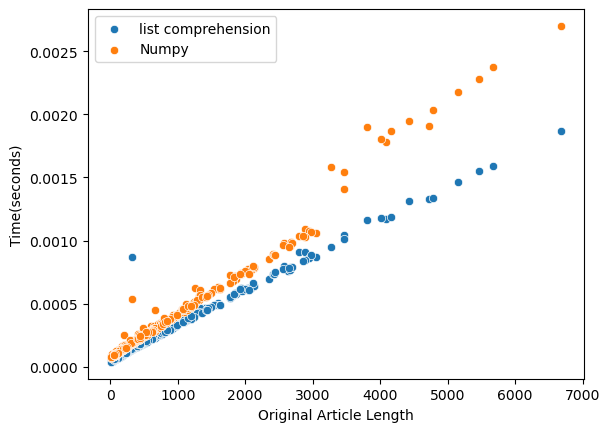

In [9]:
# plot the list_comprehension_time, numpy_time, and pandas_time against the original_article_length
sns.scatterplot(data=results, x="original_article_length", 
                y="list_comprehension_time", 
                label="list comprehension")
sns.scatterplot(data=results, x="original_article_length", 
                y="numpy_time", 
                label="Numpy")
# set the axis labels   
plt.xlabel("Original Article Length")
plt.ylabel("Time(seconds)")

NumPy does pretty well compared to Python's native list comprehension functionality, but it's still clear that the list comp is much more effective of a cleaning method than the other methods we explored. Let's use this method to clean our corpus of 15k articles (much larger than the original 500 article sample) and use that to fit our topic modelling algorithms.

If I had more time, I'd run a formal regression analysis on runtimes since there seems to be a linear relationship between the article length and the execution time for the cleaning algorithm, but I don't, so I leave something to the imagination :)

In [10]:
%%time
sampled_dataset["article"] = perform_list_comp_cleaning(sampled_dataset)["article"]

perform list comprehension cleaning: shape of dataset after cleaning: (70692, 8)
CPU times: user 14.8 s, sys: 36.7 ms, total: 14.8 s
Wall time: 14.7 s


### Model Building
In this section, I use the pre-processed datasets to train my models.

In [11]:
interesting_data = isolate_interesting_sources(dataset_1930)

perform list comprehension cleaning: shape of dataset after cleaning: (71702, 8)


In [12]:
interesting_data

,article_id,newspaper_name,edition,date,page,headline,byline,article
7414,2_1935-10-09_pNone_sn86063811_00279558601_1935...,The times-news.,01,1935-10-09,pNone,,,three intersectional game bring together michi...
7415,3_1935-10-09_pNone_sn86063811_00279558601_1935...,The times-news.,01,1935-10-09,pNone,,,vary the list by use fresh fruit alternately w...
7416,5_1935-10-09_pNone_sn86063811_00279558601_1935...,The times-news.,01,1935-10-09,pNone,SISTER MARY'S MENU,BY MARY E.. DAGUE,i be harp on break l j fast again but it impos...
7417,6_1935-10-09_pNone_sn86063811_00279558601_1935...,The times-news.,01,1935-10-09,pNone,TRADE TREND\n\n\nStill UPWARD\n\nExnansion Of ...,,activity continue it trend during great than s...
7418,7_1935-10-09_pNone_sn86063811_00279558601_1935...,The times-news.,01,1935-10-09,pNone,SKIPPER SPINS\nPIERCING YARN,,buzzard bay mass frank lynch tell this one on ...
...,...,...,...,...,...,...,...,...
432088,34_1944-12-07_pNone_sn88063294_00340588885_194...,Detroit evening times.,01,1944-12-07,pNone,,,
432089,10_1944-12-07_pNone_sn88063294_00340588885_194...,Detroit evening times.,01,1944-12-07,pNone,Van Wagner\n\n\nPortrait Hung,Times stan Correspondent,a portrait of former democratic van be in the ...
432090,15_1944-12-07_pNone_sn88063294_00340588885_194...,Detroit evening times.,01,1944-12-07,pNone,,ADVERTISEMENT,dont be of popular part popular it so easy to ...
432091,20_1944-12-07_pNone_sn88063294_00340588885_194...,Detroit evening times.,01,1944-12-07,pNone,,,have try conduct the liquor industry in the fa...


In [13]:
vectorizer = CountVectorizer(stop_words=config.VECTORIZER_LANGUAGE)
from bertopic import BERTopic

In [14]:
topic_model = BERTopic(embedding_model=config.EMBEDDING_MODEL,
                       vectorizer_model = vectorizer,
                       calculate_probabilities = False,
                       nr_topics = config.TOPIC_COUNT)
topics, probabilities = topic_model.fit_transform(sampled_dataset["article"])
topics_over_time = topic_model.topics_over_time(docs = sampled_dataset["article"], 
                                                topics = topics,
                                                timestamps = sampled_dataset["date"],
                                                nr_bins = config.TIME_BINS)
topic_model.visualize_topics_over_time(topics_over_time)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

This is an incredibly interesting exercise. Let me use this space to let out some of my thoughts.

(1) I thought I would see a lot more topics related to war, considering how much of the 20th century was spent with the United States at war.

(2) The topic for "france_french_paris_germany" spiked in the 1940s, which may have something to do with the advent of World War II.

(3) Because of my choice in subset, I only select articles that are published every 10 years. This excludes many of the articles reporting from World Wars I and II, as well as the Cold War. It's likely that the war-related topics are in the subset I didn't select.

That said, the adaptive choice of which subset to consider would dramatically change my results. If I changed the subset range step size to 5, then we'd have coverage across many of the years currently missing from the analysis. Similarly, if I ran my data specifically on the decade from 1935 - 1945 then we would likely see more articles having to do with war and Europe.

For this reason, I'm importing a more tailored dataset of newspapers from 1935 - 1945 and re-running the analysis on their texts. I'm hoping to see a difference in the topics identified by the algorithm. 

In [15]:
interesting_model = BERTopic(embedding_model=config.EMBEDDING_MODEL,
                       vectorizer_model = vectorizer,
                       calculate_probabilities = False,
                       nr_topics = config.TOPIC_COUNT)
interesting_topics, probabilities = interesting_model.fit_transform(interesting_data["article"])
topics_over_time = interesting_model.topics_over_time(docs = interesting_data["article"], 
                                                topics = interesting_topics,
                                                timestamps = interesting_data["date"],
                                                nr_bins = config.TIME_BINS)
topic_model.visualize_topics_over_time(topics_over_time)

In the section above, I add more data from the time period 1935 - 1945. I believe this time to be deeply transformational for the United States, and so I decided to take a closer look when parsing through the dataset. As opposed to studying trends that occur once every ten years, as in the previous dataset, I'm interested in seeing continuous patterns of topic growth.

I also understand that the adaptive choice of which dataset to consider introduces randomness that will skew the results of my analysis. Because this isn't a ranodmized test used to determine any sort of causation, I'm okay with this.

I think this topic model is much more interesting. Since the C-TF-IDF is trained to consider temporal relationships between words, the timeframe matters much more than in previous models. A few examples are below.

(1) The newly-founded Soviet Union was formed in 1922. We'll see the terms "Russia" and "Soviet" used interchangably throughout the remaining 20 years of analysis, hence why they're tied under the same topic number.

(2) Polyester was also commercialized around this time, which gave rise to the term "rayon" in the 1920s. This demonstrates that Americans have struggled with the term "polyester" even from the beginning.

(3) Interestingly, topics referencing Hitler and Nazi Germany peaked pre-World War II, which began in 1944. I chose this timeframe specifically becuase I thought the trace of war-associated terms would spike, but this doesn't seem to be the case.

(4) Probably the most interesting trend is in relation to labor. Phrases associated with workers, strikes, and unionization spiked shortly after the end of World War II, in 1945.

In [16]:
topic_model_1930 = BERTopic(embedding_model=config.EMBEDDING_MODEL,
                       vectorizer_model = vectorizer,
                       calculate_probabilities = False,
                       nr_topics = config.TOPIC_COUNT)
topics_1930, probabilities = topic_model_1930.fit_transform(sampled_dataset_1930["article"])
topics_over_time = topic_model_1930.topics_over_time(docs = sampled_dataset_1930["article"], 
                                                topics = topics_1930,
                                                timestamps = sampled_dataset_1930["date"],
                                                nr_bins = config.TIME_BINS)
topic_model_1930.visualize_topics_over_time(topics_over_time)

After calculating the coherence score of my initial model, my model achieved a coherence of ~0.48. This doesn't seem particularly high, and the internet suggests a few methods of increasing to coherence score.

The most attractive is lemmatization. Lemmatization, much like stemming, reduces a word to its root. The idea is that the root of a word is more helpful to topic modelling than the historically accurate term itself.

An interesting part of lemmatization is that it also requires that I tag the word with a part of speech. Nouns, for example, should be identified as such in order to avoid improperly shortening a word. When the tagging is complete, the documents are reduced to a list of lemmas and roots as opposed to unnecessarily long words.

As a final analysis, I take the news data from 1935 - 1945 and specifically look for sources that I'm familiar with. I call these "interesting sources", but it's really just a more focused analysis on sources from Michigan and newspapers from ethnic minorities. I also include the Phoenix Jewish Sun because it's one of the few Jewish-serving newspapers in the source list, which makes it interesting enough.

In [17]:
from model_evaluation import score_models

models = [topic_model, interesting_model, topic_model_1930]
datasets = [sampled_dataset, interesting_data, sampled_dataset_1930]

scores = score_models(models, datasets)

print(scores)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.5816428049287101, 0.5142390656859703, 0.5854080569365631]


Funny enough, lemmatization doesn't seem to have done much for coherence, which still sits around 0.48. But it's definitely interesting to learn the sort of metrics used to score the performance of unsupervised learning models. I'll keep the lemmatization code in there for now and hopefully someone will get some use out of it.

Some interesting topics:

Topic 20 (german, soviet, front, railroad) - This topic seems to track topics relating to Germany, the Soviet Union, and the Eastern Front of World War II, which took place in Europe. It makes sense that railroads would be mentioned since the use of railoroads for transporting war supplies and troops was a key trait of armed conflict in the 20th century.

Topic 34 (russia, soviet, stain, foreign) - This topic, distinct from the topic focused on Germany, seems distinct to the newly-formed Soviet Union. At the start of World War II, the Soviet Union was a little over 17 years old and became a strong ally to the Western Powers. As opposed to covering war, this topic seems to track the growth of the newly-founded nation.

Topics 74 and 77 (berlin, german, minister, alliance, peace, world, war) - These topics are more specifically focused on war and explicitly use terms that we would associate with World War II. Given the topic representation, I would expect this sort of news to be analysis-focused as opposed to reporting on events. The difference being that news-focused reporting focuses on describing the events when the happen, whereas analysis-focused reporting focuses on describing trends in news events from the past few years. The analysis-focused reporting, the work of historians and public scholars, is where public opinion on historical events is formed.